In [1]:
import torch
import jovian
import torchvision
import matplotlib
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
import os
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [2]:
#load data
dataframe = pd.read_csv("understat.csv")

#choose columns
input_cols=list(dataframe.columns)[4:11]
output_cols = ['position']
input_cols, output_cols

(['matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts'],
 ['position'])

In [3]:
def dataframe_to_arrays(dataframe):
    dataframe_loc = dataframe.copy(deep=True)
    inputs_array = dataframe_loc[input_cols].to_numpy()
    targets_array = dataframe_loc[output_cols].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe)

inputs = torch.from_numpy(inputs_array).type(torch.float)
targets = torch.from_numpy(targets_array).type(torch.float)

dataset = TensorDataset(inputs, targets)

In [4]:
train_ds, val_ds = random_split(dataset, [548, 136])
batch_size=50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [5]:
class Model_xPosition(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size) 
        
    def forward(self, xb): 
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out,targets)   
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch {} loss: {:.4f}".format(epoch+1, result['val_loss']))
            
            
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [6]:
input_size = len(input_cols)
output_size = len(output_cols)
model=Model_xPosition()

In [7]:
epochs = 1000
lr = 1e-5
learning_proccess = fit(epochs, lr, model, train_loader, val_loader)

Epoch 100 loss: 2.2152
Epoch 200 loss: 1.8737
Epoch 300 loss: 1.8362
Epoch 400 loss: 1.7904
Epoch 500 loss: 1.7507
Epoch 600 loss: 1.7174
Epoch 700 loss: 1.6977
Epoch 800 loss: 1.6847
Epoch 900 loss: 1.6743
Epoch 1000 loss: 1.6645


In [8]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()

    return "Target: "+str(target)+"          Predicted: "+str(prediction)+"\n"

In [9]:
def prediction(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    predicted = predictions[0].detach()
    return predicted

In [10]:
with open("result.txt", "a+") as file:
    for i in range(0, len(val_ds), 1):
        input_, target = val_ds[i]
        file.write(str(predict_single(input_, target, model)))

In [11]:
expected = []
predicted = []
for i in range(0, len(val_ds), 1):
        input_, target = val_ds[i]
        expected.append(float(target))
        predicted.append(float(prediction(input_, target, model)))

MSE = mean_squared_error(expected, predicted)
MAE = mean_absolute_error(expected, predicted)

with open("metrics.txt", "a+") as file:
    file.write("Mean squared error: MSE = "+ str(MSE) + "\n")
    file.write("Mean absolute error: MAE = "+ str(MAE)+ "\n")

with open("MSE.txt", "a+") as file:
    file.write(str(MSE) + "\n")

In [12]:
with open('MSE.txt') as file:
    y_MSE = [float(line) for line in file if line]
    x_builds = list(range(1, len(y_MSE) + 1))

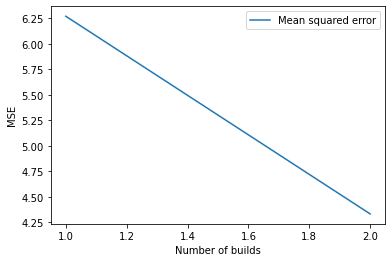

<Figure size 432x288 with 0 Axes>

In [13]:
plt.xlabel('Number of builds')
plt.ylabel('MSE')
plt.plot(x_builds, y_MSE, label='Mean squared error')
plt.legend()
plt.show()
plt.savefig('RMSplot.png')

In [ ]:
!jupyter nbconvert --to script ml_pytorch.ipynb